In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
import warnings
warnings.filterwarnings("ignore")

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

Загрузим данные.

In [4]:
df = pd.read_csv("~/GitHubRepos/FinancialEconometrics/DataWork/Data/General_ds_cleaned.csv", parse_dates=["date"])
df = df[["date", "beta0", "beta1", "beta2", "tau"]]
df.set_index("date", drop=True, inplace=True)
df

,beta0,beta1,beta2,tau
date,,,,
2003-01-04,850.031170,-299.987941,100.005078,0.000016
2003-01-05,850.031097,-299.988336,100.004988,0.000002
2003-01-08,850.032418,-299.987725,100.005295,0.000013
2003-01-09,850.035191,-299.986787,100.005729,0.000015
2003-01-10,850.030915,-299.988803,100.004964,0.000012
...,...,...,...,...
2023-11-27,1178.762726,392.865962,-572.515166,0.344359
2023-11-28,1176.287596,349.812713,-497.037336,0.348622
2023-11-29,1176.081378,456.633996,-658.044054,0.306983


In [5]:
n_horizon = 5
dates_from_struct_ms = np.array([0, 657, 1384, 3943, 4502])


time_to_fit = np.maximum((dates_from_struct_ms - n_horizon), np.zeros(len(dates_from_struct_ms))).astype(int)
time_to_predict = dates_from_struct_ms

epoch = 2
df_train, df_test = df[time_to_fit[epoch]:time_to_fit[epoch + 1]], df[time_to_fit[epoch + 1]:time_to_predict[epoch + 1]]
df_train

,beta0,beta1,beta2,tau
date,,,,
2008-08-04,787.698837,-257.167676,-117.160057,1.514857
2008-08-05,793.544014,-252.057464,-97.531912,1.492880
2008-08-06,788.822921,-250.264997,0.011639,2.247401
2008-08-07,789.968019,-245.951561,0.000642,2.146876
2008-08-08,792.235847,-247.701082,0.002386,2.218359
...,...,...,...,...
2019-09-27,876.193534,-227.925309,-182.876418,5.695779
2019-09-30,874.734127,-221.771567,-206.788705,5.128847
2019-10-07,875.012126,-231.414254,-214.985989,5.992436


In [6]:
def adjust(val, length= 6): return str(val).ljust(length)

def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 

    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

Рассмотрим ACF для отбора параметров в ARIMA.

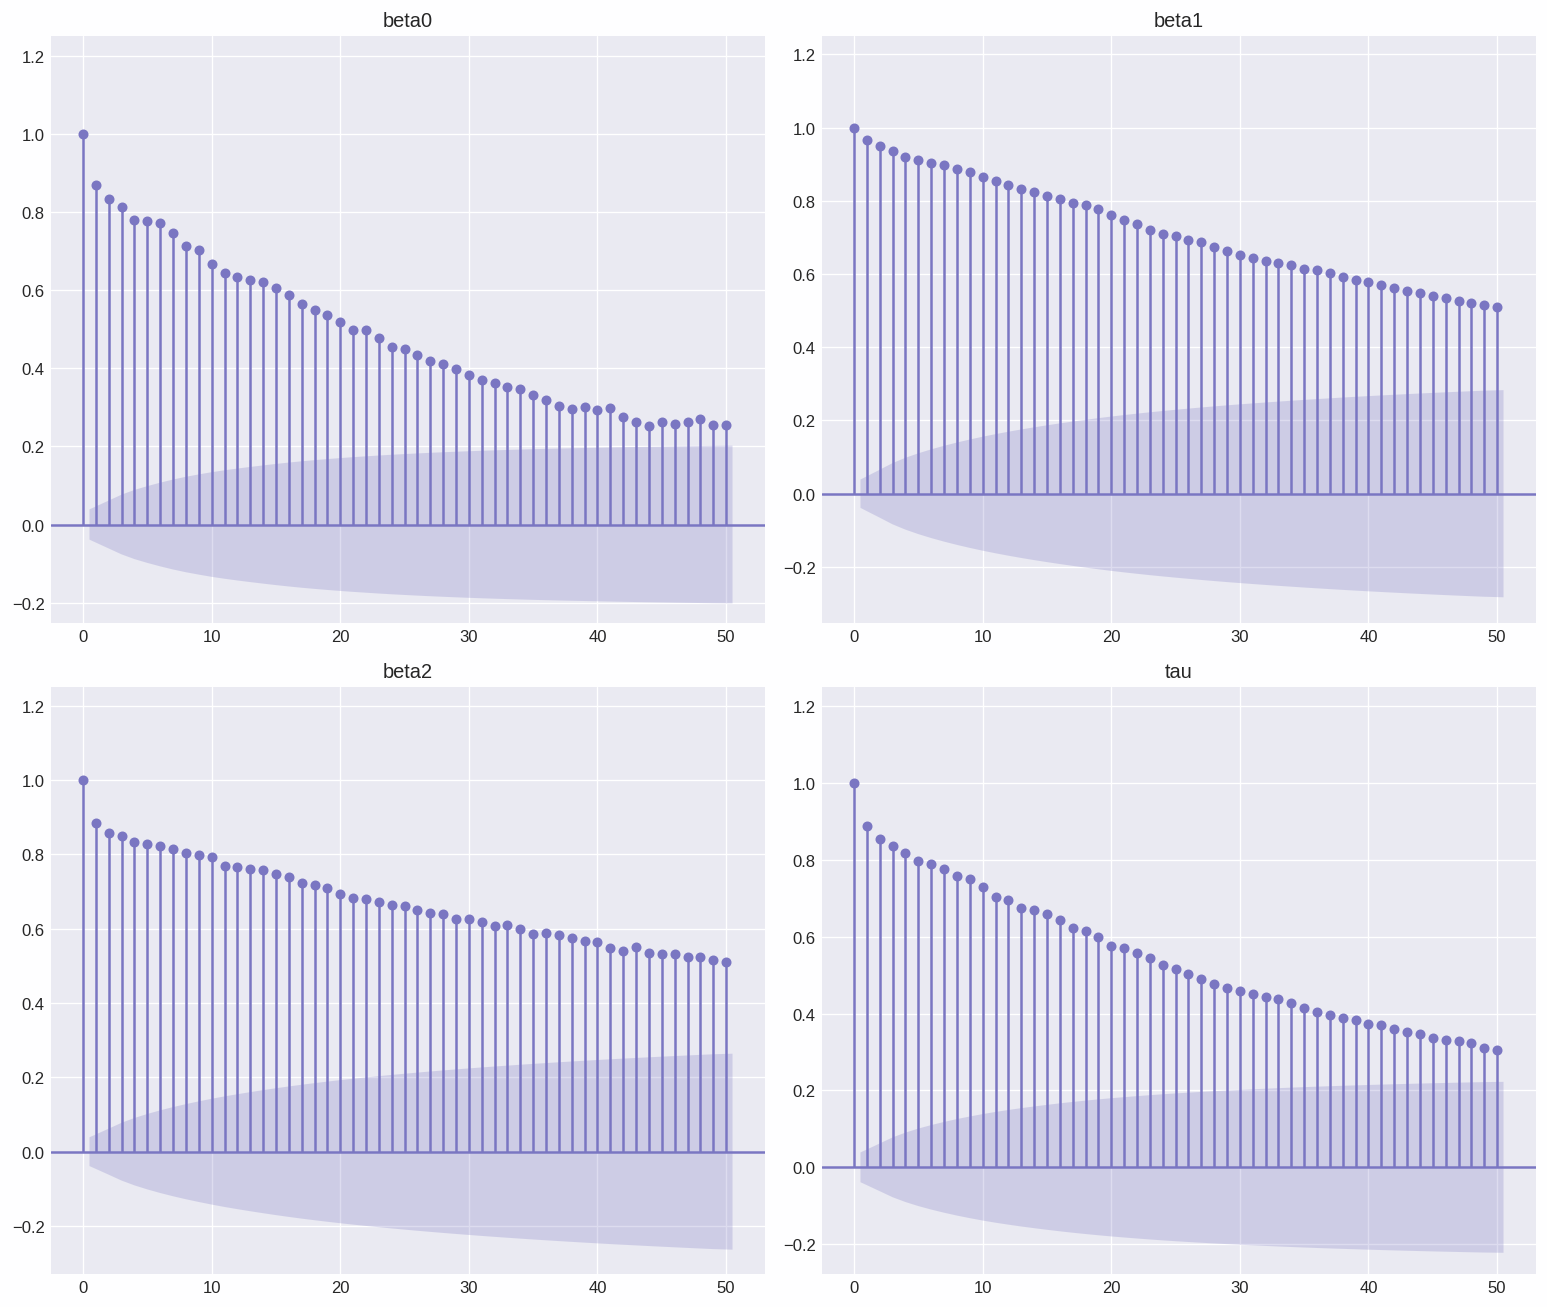

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(13,11))
for i, ax in enumerate(axes.flat):
    data = df_train[df.columns[i]]
    plot_acf(data, auto_ylims=True, lags=50, ax=ax, title=df.columns[i])

plt.tight_layout();

Возьмем одну разность и одновременно проверим ADF и ACF.

In [8]:
df_train_differenced = df_train.diff().dropna()
for name, column in df_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "beta0" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.0588
 No. Lags Chosen       = 24
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "beta1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.9133
 No. Lags Chosen       = 26
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "beta2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    =

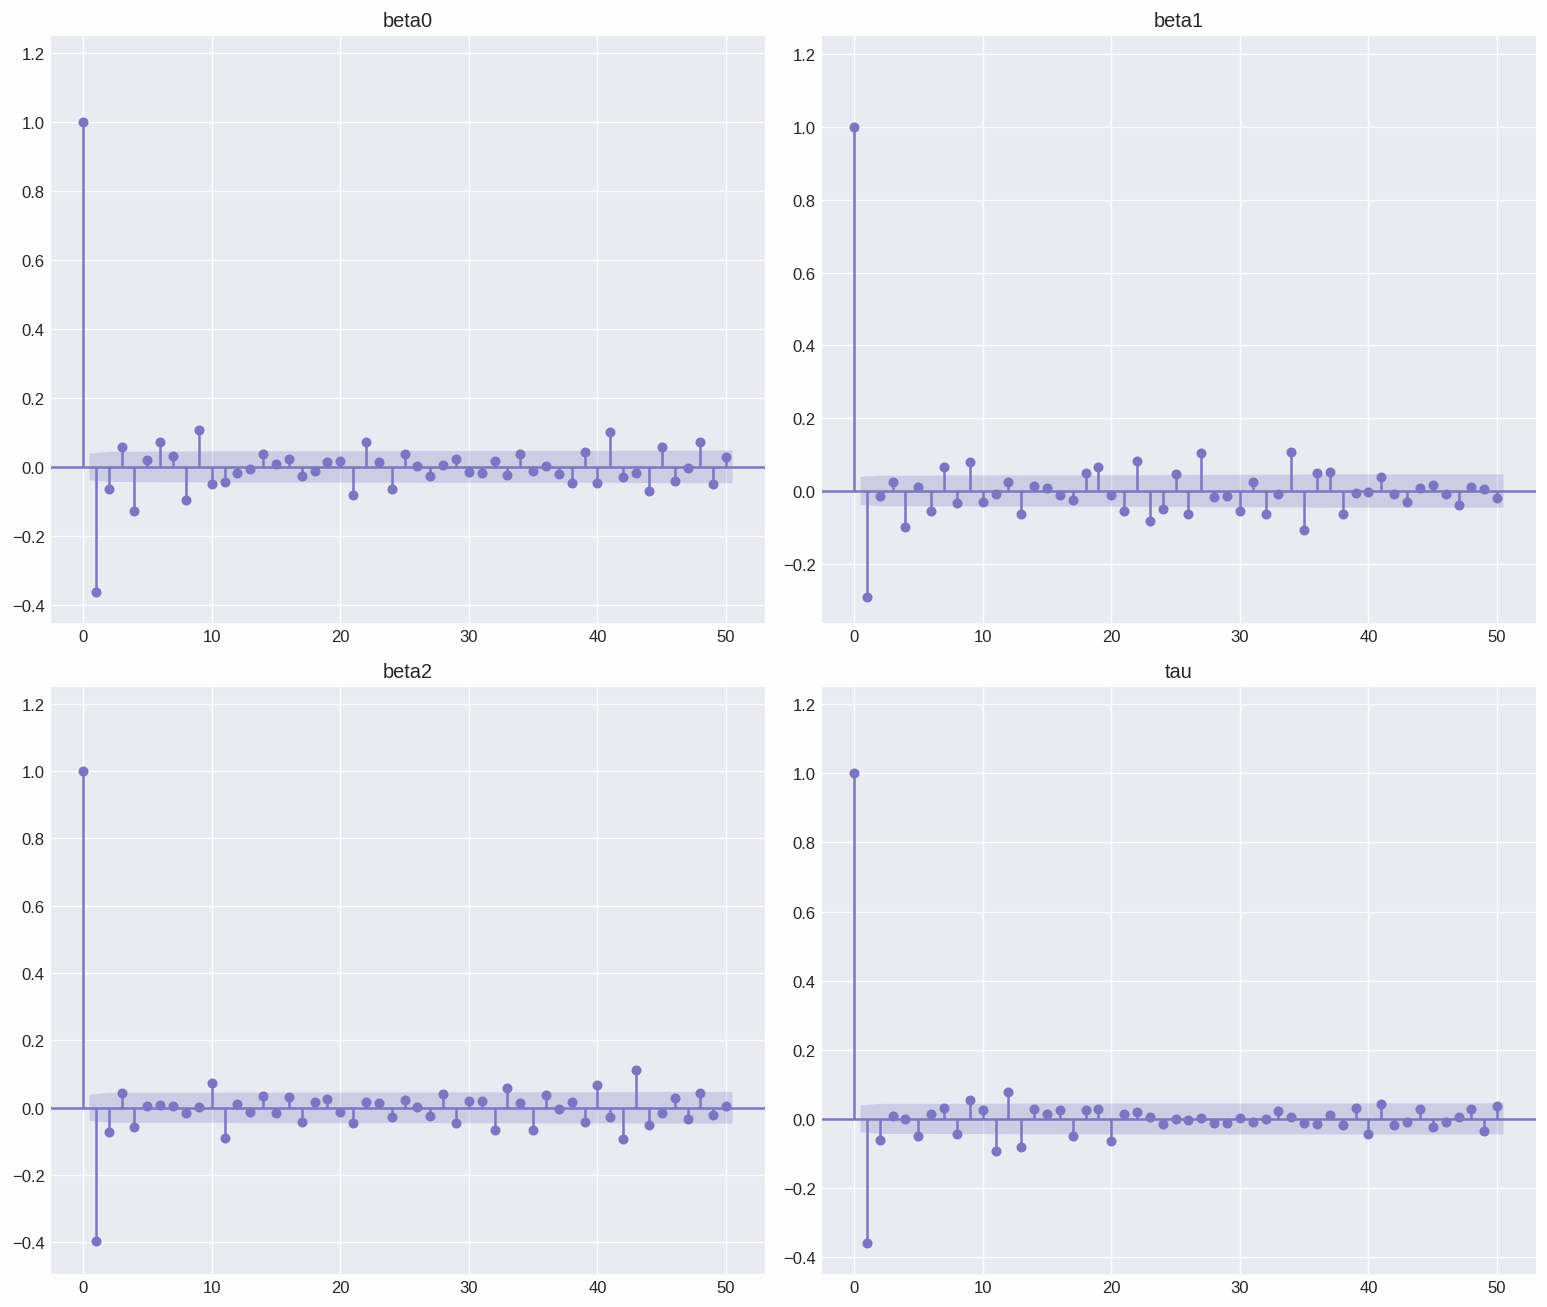

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(13,11))
for i, ax in enumerate(axes.flat):
    data = df_train_differenced[df_train_differenced.columns[i]]
    plot_acf(data, auto_ylims=True, lags=50, ax=ax, title=df_train_differenced.columns[i])

plt.tight_layout();

Теперь мы точно убедились в том, что стационарность есть. Из этого мы получили параметр $d = 1$ в ARIMA. Далее будем искать оптимальный параметр p. Для этого построим PACF.

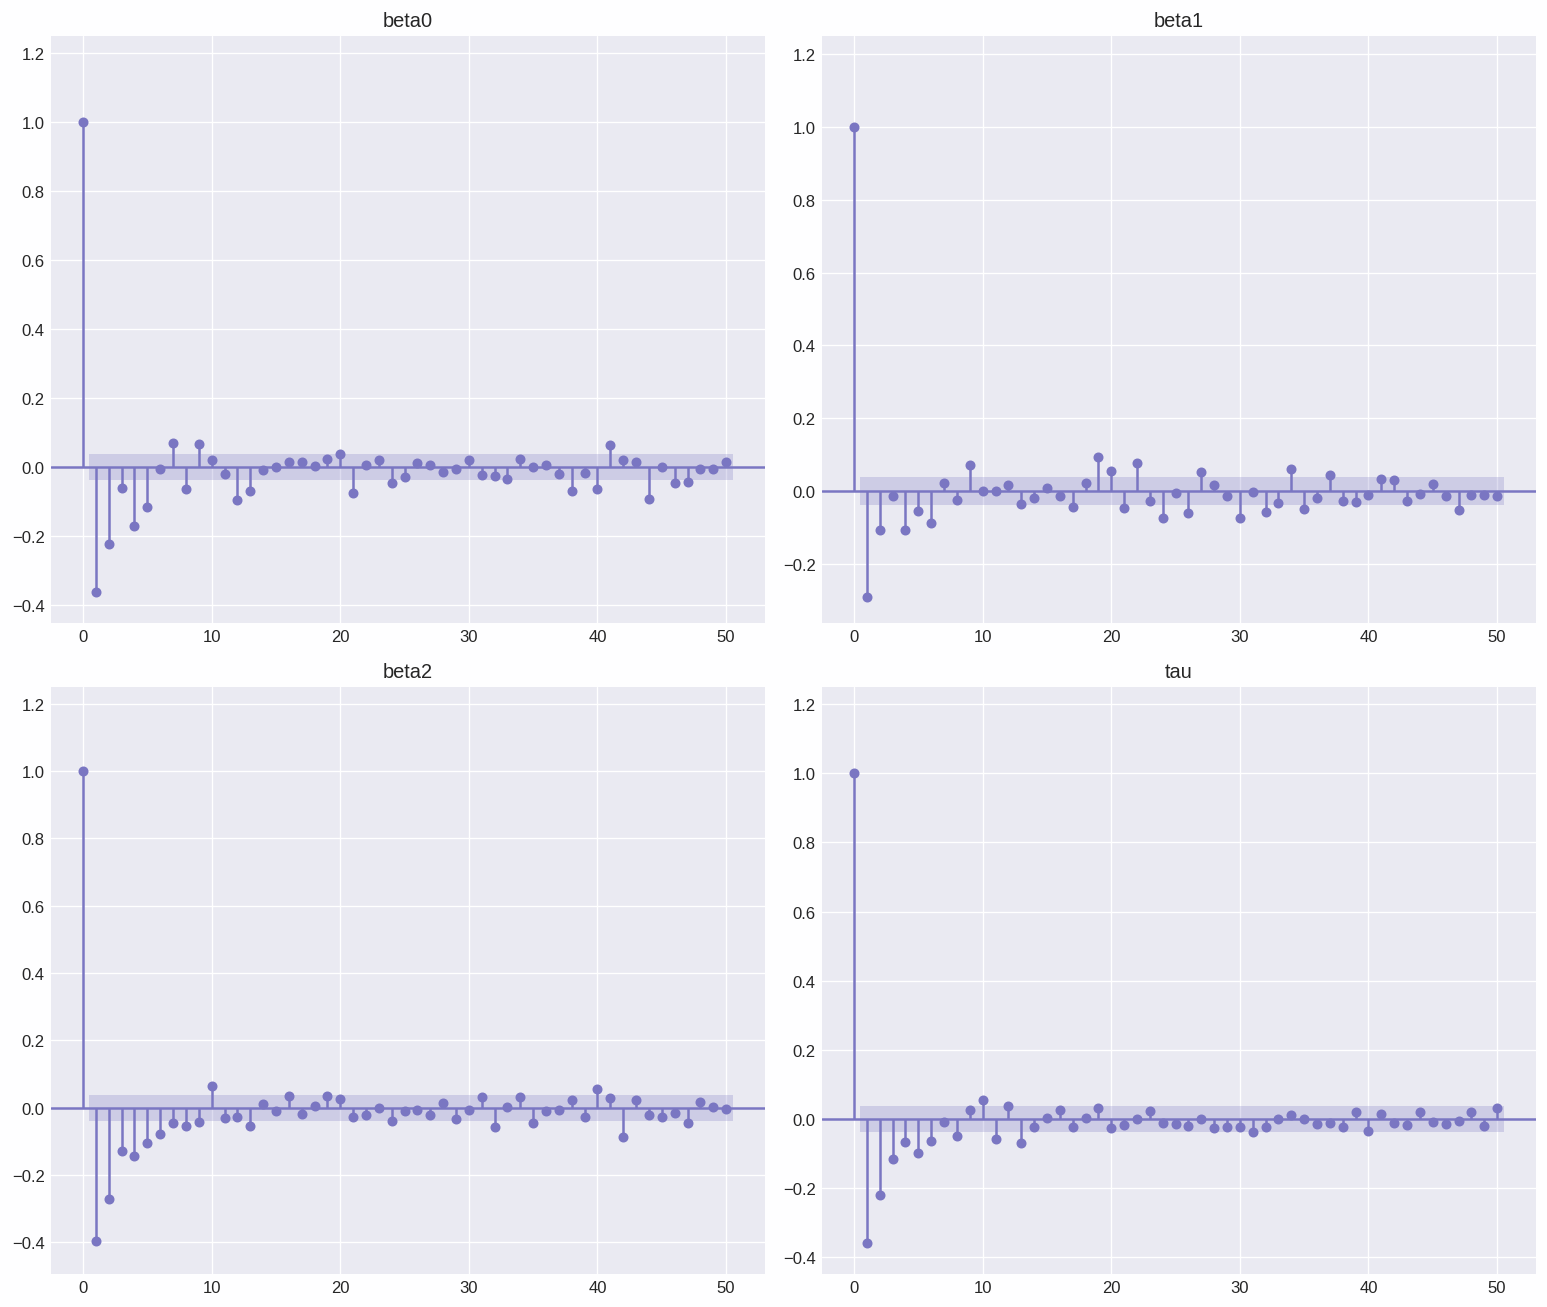

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(13,11))
for i, ax in enumerate(axes.flat):
    data = df_train_differenced[df_train_differenced.columns[i]]
    plot_pacf(data, auto_ylims=True, lags=50, ax=ax, title=df_train_differenced.columns[i])

plt.tight_layout();

Возьмем за начальный fit параметры (1,1,1) и посмотрим на его AIC.

In [11]:
def find_best_parametrs(df_train):
    max_parametrs_for_q = 4
    df_fc = df_train.copy()
    mas_best_param = []

    for colname in df_fc.columns:
        aic_dict = {}
        arima_model = ARIMA(df_fc[colname])
        for i in np.arange(1,max_parametrs_for_q):
            for j in np.arange(1,max_parametrs_for_q):
                for l in np.arange(1,max_parametrs_for_q):
                    result = arima_model.fit((i,j,l))
                    aic_dict[f"({i}, {j}, {l})"] = result.aic
        aic_dict = pd.DataFrame(aic_dict.values(), index=aic_dict.keys(), columns=[colname])
        mas_best_param.append(aic_dict[aic_dict == aic_dict[colname].min()].dropna())

    return mas_best_param
    

In [12]:
find_best_parametrs(df_train)

[                  beta0
 (1, 3, 1)  31115.899602
 (1, 3, 2)  31115.899602
 (1, 3, 3)  31115.899602,
                   beta1
 (1, 1, 1)  34459.505456
 (1, 1, 2)  34459.505456
 (1, 1, 3)  34459.505456,
                  beta2
 (3, 2, 1)  36697.29216
 (3, 2, 2)  36697.29216
 (3, 2, 3)  36697.29216,
                     tau
 (1, 2, 1)  12411.019657
 (1, 2, 2)  12411.019657
 (1, 2, 3)  12411.019657]

Получили лучшие варианты параметров по AIC. Для наглядности посмотрим графики на тренировочных данных.

In [13]:
arima_model_beta0 = ARIMA(df_train["beta0"], order= (1, 3, 1)).fit()
arima_model_beta1 = ARIMA(df_train["beta1"], order= (1, 1, 1)).fit()
arima_model_beta2 = ARIMA(df_train["beta2"], order=(3, 2, 1)).fit()
arima_model_tau = ARIMA(df_train["tau"], order=(1, 2, 1)).fit()

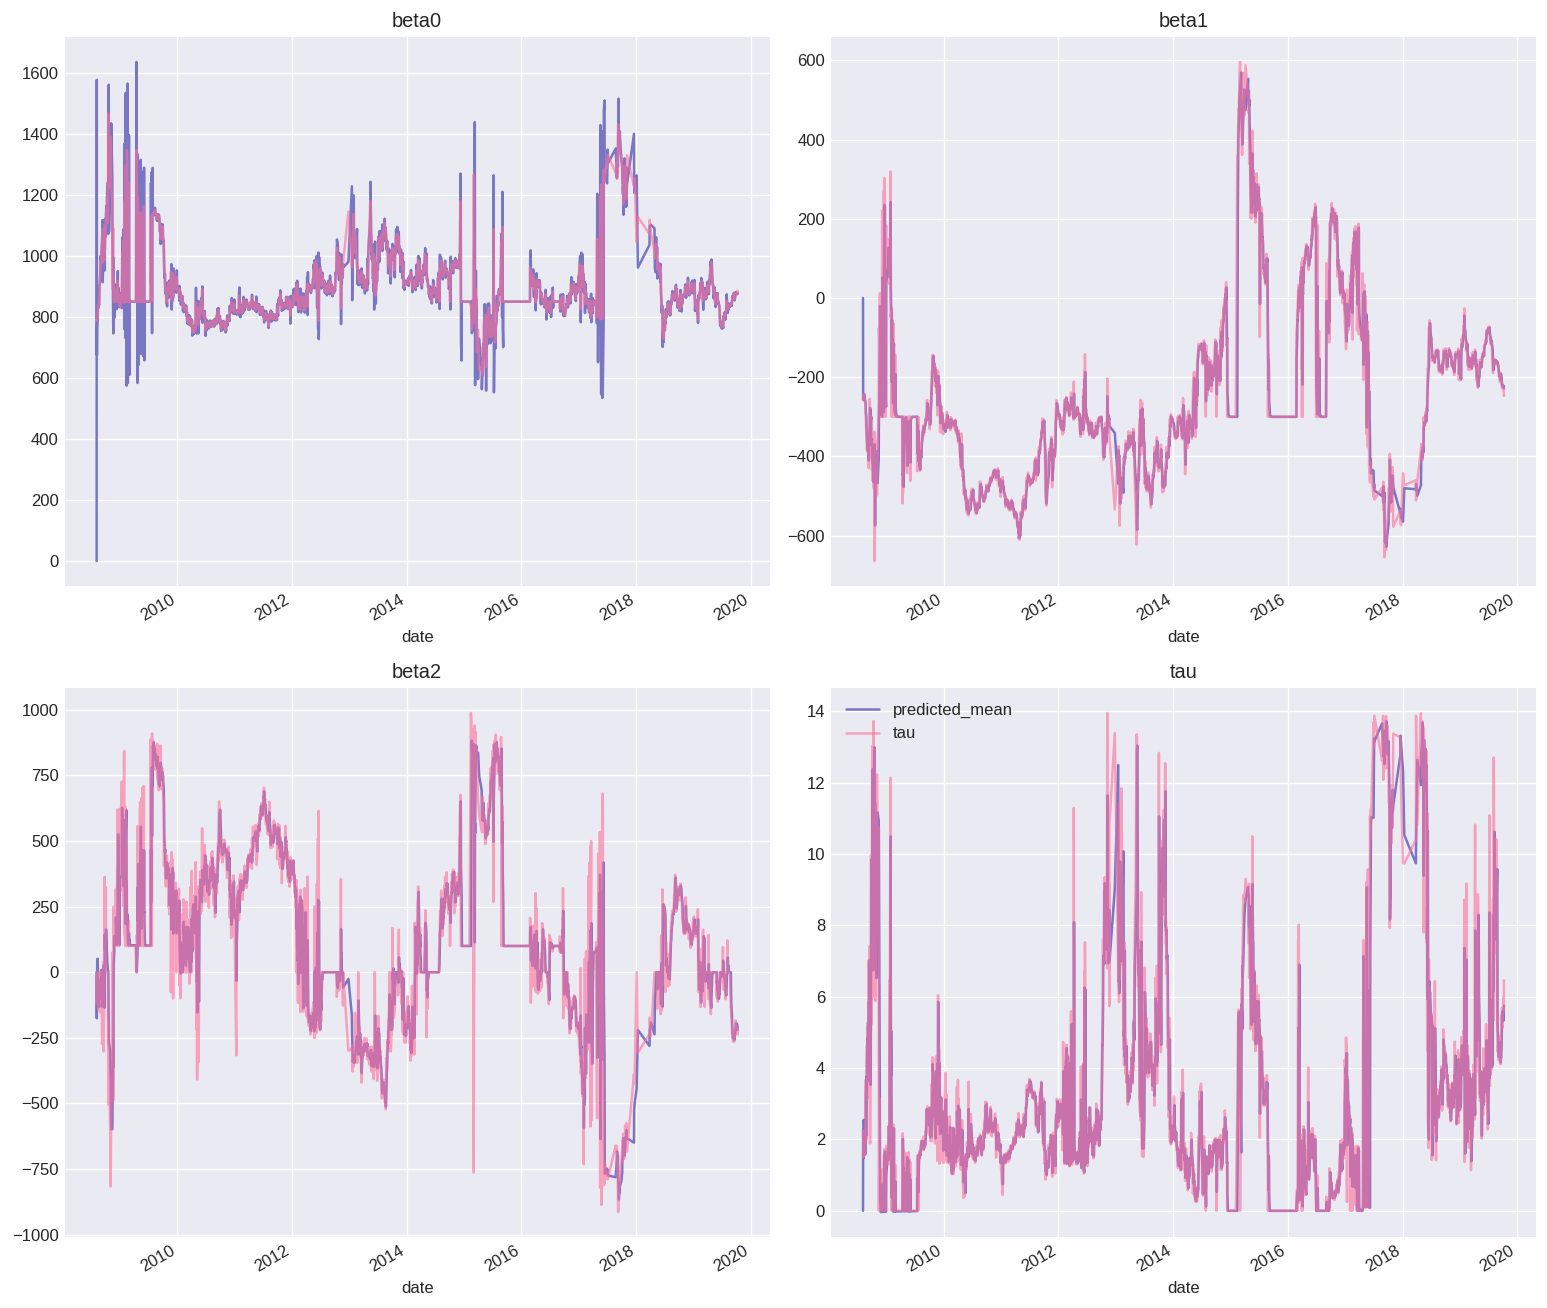

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(13,11))
axes.flat[0].set_title("beta0")
arima_model_beta0.predict().plot(ax=axes.flat[0])
df_train["beta0"].plot(ax=axes.flat[0])
axes.flat[1].set_title("beta1")
arima_model_beta1.predict().plot(ax=axes.flat[1])
df_train["beta1"].plot(ax=axes.flat[1])
axes.flat[2].set_title("beta2")
arima_model_beta2.predict().plot(ax=axes.flat[2])
df_train["beta2"].plot(ax=axes.flat[2])
axes.flat[3].set_title("tau")
arima_model_tau.predict().plot(ax=axes.flat[3])
df_train["tau"].plot(ax=axes.flat[3])

plt.legend(loc='best')
plt.tight_layout();

Теперь же обучимся и посмотрим на метрики.

In [15]:
df_result = df_test
df_result["beta0_forecast"] = np.array(arima_model_beta0.forecast(steps=n_horizon))
df_result["beta1_forecast"] = np.array(arima_model_beta1.forecast(steps=n_horizon))
df_result["beta2_forecast"] = np.array(arima_model_beta2.forecast(steps=n_horizon))
df_result["tau_forecast"] = np.array(arima_model_tau.forecast(steps=n_horizon))
df_result


,beta0,beta1,beta2,tau,beta0_forecast,beta1_forecast,beta2_forecast,tau_forecast
date,,,,,,,,
2019-10-10,871.472878,-238.861462,-252.555101,5.546608,890.895623,-240.703323,-218.933003,6.157287
2019-10-11,871.401875,-236.827888,-250.549455,5.949593,898.330259,-239.392603,-221.746415,6.267971
2019-10-14,880.116830,-248.834162,-246.235740,6.604045,904.144602,-239.130236,-222.063226,6.230770
2019-10-15,826.110447,-193.436764,-212.103603,5.188040,910.947551,-239.077718,-220.639158,6.246685
2019-10-16,829.433273,-200.437511,-181.145054,6.040058,917.149507,-239.067206,-221.044349,6.243523


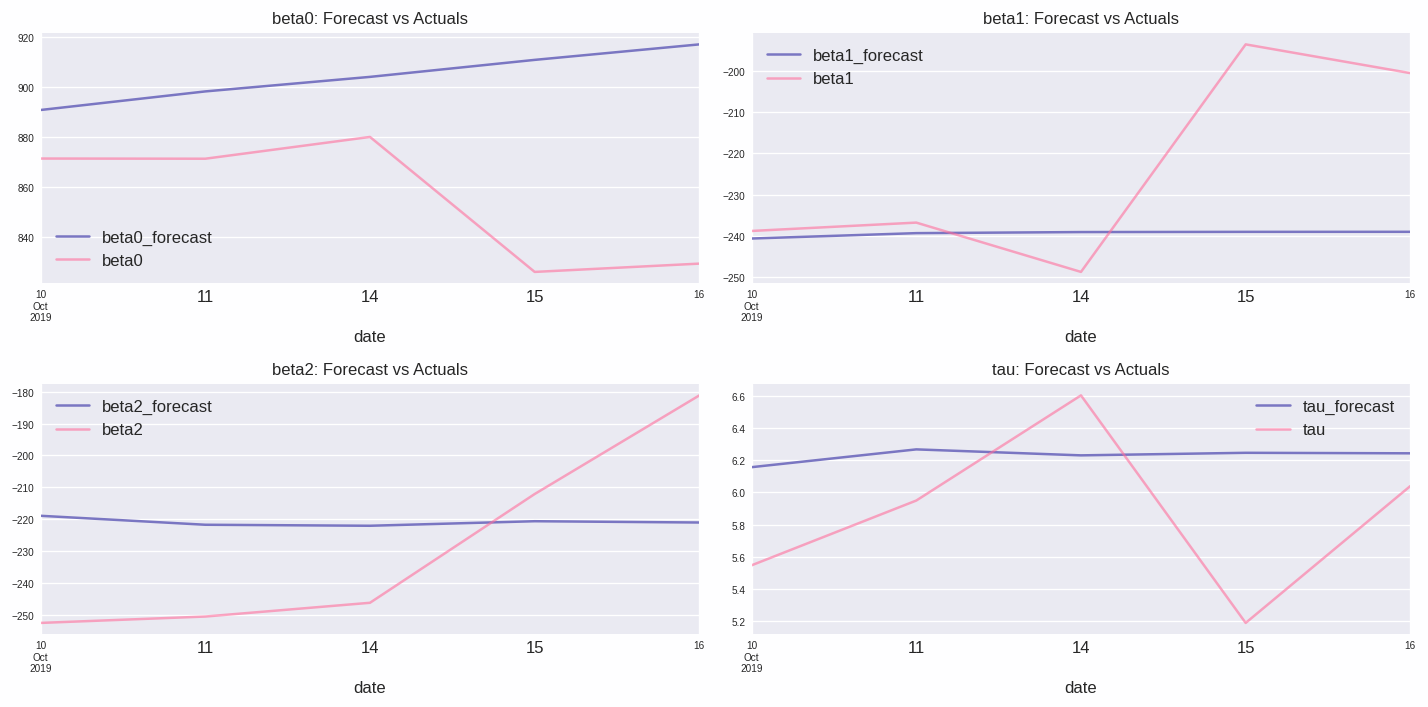

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(12,6))
for i, (col,ax) in enumerate(zip(df_result.columns, axes.flatten())):
    df_result[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x', tight=True)
    df_result[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals", fontsize=10)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)


plt.tight_layout();
plt.savefig("ARIMAfcst.pdf")


In [179]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)    
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/actual)
    rmse = np.mean((forecast - actual)**2)**.5
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

In [180]:
for col_name in df.columns:
    print('Forecast Accuracy of: ' + col_name)
    accuracy_prod = forecast_accuracy(df_result[col_name + '_forecast'].values, df_test[col_name])
    for k, v in accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: beta0
mape   :  0.0578
me     :  48.5869
mae    :  48.5869
mpe    :  0.0578
rmse   :  57.57
Forecast Accuracy of: beta1
mape   :  0.0972
me     :  -15.7947
mae    :  19.6762
mpe    :  0.0816
rmse   :  27.1274
Forecast Accuracy of: beta2
mape   :  0.1214
me     :  7.6326
mae    :  27.0065
mpe    :  -0.0172
rmse   :  29.0144
Forecast Accuracy of: tau
mape   :  0.0916
me     :  0.3636
mae    :  0.5129
mpe    :  0.069
rmse   :  0.5959
